# Food-101 Classification

## Part 4: Classification with Mixupand Image Augmentation

This notebook removes label smoothing

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from shutil import copyfile

In [3]:
bs = 96

In [4]:
path = Path('../../data/food-101/')
path_img = path/'images'
path_meta = path/'meta'

In [5]:
path_train = path/'data/train'

In [6]:
x = torch.rand([32, 256, 1024], device=0, requires_grad=True)

In [8]:
(x@x.transpose(1,2)).shape

torch.Size([32, 256, 256])

In [9]:
del x
gc.collect()

40

# Creating the Dataloader

We create the dataloader using the same methods as the previous notebook. We keep the same validation split and pass the same random seed to ensure we are evaluating performance against the same validation dataset.

In [10]:
tfms = get_transforms(
                        do_flip=True,
                        flip_vert=True,
                        max_rotate=10.0,
                        max_zoom = 1.1,
                        max_lighting=0.25,
                        max_warp=0.25,
                        )

In [11]:
data = (ImageList.from_folder(path_train).split_by_rand_pct(0.07, seed=42)
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=256)
                                       .databunch(bs=bs, num_workers=6))

In [12]:
data

ImageDataBunch;

Train: LabelList (70448 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\..\data\food-101\data\train;

Valid: LabelList (5302 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
clam_chowder,macaroni_and_cheese,tacos,macaroni_and_cheese,lobster_roll_sandwich
Path: ..\..\data\food-101\data\train;

Test: None

I found that the combination of mixup, image augmentation and label smoothing applied extremely strong regularization to the model, and I needed to reduce dropout and weight decay slightly. Previously we used a dropout of 0.5 in the Linear head and a weight decay coefficient of 1e-2. For this model I relax that slightly to a dropout value of 0.4 and a weight decay coefficient of 5e-3.

In [13]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn = learn.mixup()

In [14]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True),
 functools.partial(<class 'fastai.callbacks.mixup.MixUpCallback'>, alpha=0.4, stack_x=False, stack_y=True)]

In [15]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [16]:
learn = learn.to_fp16(dynamic=True);
learn.freeze()

In [17]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


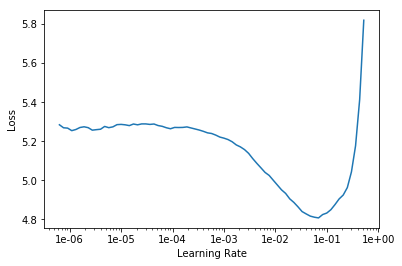

In [18]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(8, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,2.929667,1.756295,0.443040,07:39
1,2.719643,1.581919,0.400038,07:40
2,2.579518,1.418446,0.366843,07:45
3,2.448495,1.291717,0.333082,07:52
4,2.383423,1.198976,0.310826,07:38
5,2.305623,1.126367,0.287250,07:31
6,2.198137,1.072726,0.273670,07:34
7,2.181425,1.060332,0.273482,07:30


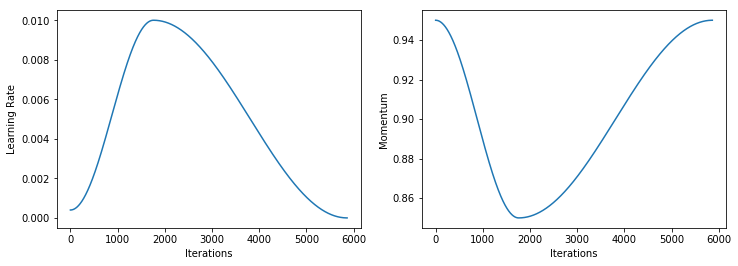

In [19]:
learn.recorder.plot_lr(show_moms=True)

In [20]:
learn.save('food_mix_aug_nls-1')

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(12, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.176329,1.037894,0.268955,07:40
1,2.115432,1.024918,0.266503,07:40
2,2.134259,1.050933,0.279140,07:41
3,2.079583,0.969653,0.255941,07:40
4,2.019607,0.935771,0.244813,07:41
5,1.925202,0.850769,0.224066,07:39
6,1.859751,0.803545,0.211430,07:40
7,1.807192,0.767126,0.201999,07:39
8,1.749269,0.731172,0.196907,07:40
9,1.711165,0.698765,0.188042,07:39


In [23]:
learn.save('food_mix_aug_nls-2')

In [17]:
learn.load('food_mix_aug_nls-2');

In [24]:
interp = ClassificationInterpretation.from_learner(learn.to_fp32())
losses,idxs = interp.top_losses()

Confused classes look basically the same as other models

In [25]:
interp.most_confused(min_val=4)

[('dumplings', 'gyoza', 10),
 ('prime_rib', 'steak', 9),
 ('chocolate_cake', 'chocolate_mousse', 8),
 ('filet_mignon', 'steak', 6),
 ('ice_cream', 'chocolate_mousse', 6),
 ('steak', 'filet_mignon', 6),
 ('steak', 'prime_rib', 6),
 ('beef_tartare', 'tuna_tartare', 5),
 ('cheesecake', 'strawberry_shortcake', 5),
 ('gnocchi', 'ravioli', 5),
 ('ice_cream', 'frozen_yogurt', 5),
 ('pulled_pork_sandwich', 'hamburger', 5),
 ('sushi', 'sashimi', 5),
 ('french_toast', 'bread_pudding', 4),
 ('huevos_rancheros', 'breakfast_burrito', 4),
 ('huevos_rancheros', 'croque_madame', 4),
 ('pho', 'ramen', 4),
 ('pork_chop', 'steak', 4),
 ('red_velvet_cake', 'cup_cakes', 4),
 ('scallops', 'foie_gras', 4),
 ('steak', 'pork_chop', 4),
 ('tuna_tartare', 'beef_tartare', 4)]

# Training on 512x512

Now we move to training on 512x512 images. We will follow a similar strategy. First we will train only the linear head. Then we will unfreeze and train the entire model.

In [27]:
data_hr = (ImageList.from_folder(path_train).split_by_rand_pct(0.07, seed=42)
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=512)
                                       .databunch(bs=22, num_workers=6))

In [28]:
data_hr

ImageDataBunch;

Train: LabelList (70448 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\..\data\food-101\data\train;

Valid: LabelList (5302 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
clam_chowder,macaroni_and_cheese,tacos,macaroni_and_cheese,lobster_roll_sandwich
Path: ..\..\data\food-101\data\train;

Test: None

In [29]:
learn.data = data_hr
learn = learn.to_fp16(dynamic=True)
learn.freeze()

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


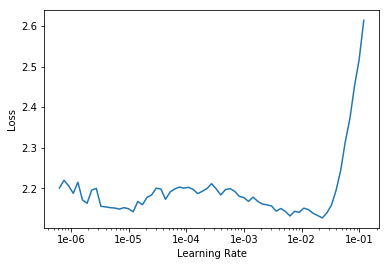

In [31]:
learn.recorder.plot(skip_end=10)

In [32]:
learn.fit_one_cycle(5, max_lr=slice(3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.873444,0.724059,0.191814,20:43
1,1.877570,0.705276,0.184647,20:44
2,1.845359,0.685497,0.179366,20:56
3,1.751669,0.646004,0.170690,20:52
4,1.758182,0.633430,0.166164,20:43


In [33]:
learn.save('food_mix_aug_nls-3')

In [21]:
learn.load('food_mix_aug_nls-3');

In [34]:
learn.unfreeze()

In [35]:
learn.fit_one_cycle(15, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.763890,0.630334,0.167673,27:19
1,1.706066,0.631699,0.168050,27:18
2,1.702754,0.630696,0.165975,27:20
3,1.695131,0.617916,0.159562,27:21
4,1.727887,0.624323,0.170879,27:20
5,1.681229,0.606037,0.157676,27:24
6,1.670815,0.603223,0.156733,27:29
7,1.662757,0.589788,0.154093,27:25
8,1.626523,0.592657,0.151829,27:23
9,1.599642,0.577183,0.149378,27:31


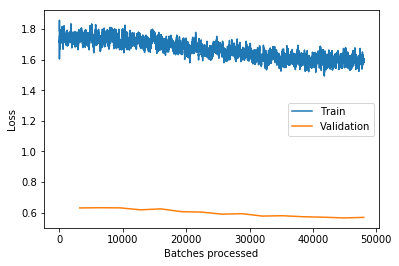

In [36]:
learn.recorder.plot_losses()

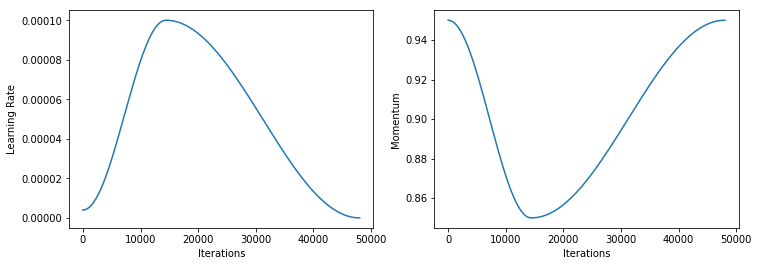

In [37]:
learn.recorder.plot_lr(show_moms=True)

In [38]:
learn.save('food_mix_aug_nls-4')

In [39]:
learn.fit_one_cycle(10, max_lr=slice(5e-7,5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,1.616786,0.570943,0.147869,27:19
1,1.630078,0.571698,0.145228,27:24
2,1.591234,0.578393,0.147491,27:25
3,1.592601,0.573397,0.147303,27:25
4,1.625430,0.570945,0.144285,27:27
5,1.596021,0.568361,0.144851,27:26
6,1.554061,0.565713,0.147492,27:23
7,1.528010,0.568734,0.144285,27:23
8,1.558473,0.561481,0.144474,27:22
9,1.549650,0.567611,0.146737,27:19


In [40]:
learn.save('food_mix_aug_nls-5')

At this point I stopped training.


# Prediction

We will predict on the test set twice - once without TTA and once with TTA.

## Prediction Without TTA

Here we make a prediction dataloader that contains the test set.

In [41]:
tfms = get_transforms(
                        do_flip=True,
                        flip_vert=True,
                        max_rotate=10.0,
                        max_zoom = 1.1,
                        max_lighting=0.25,
                        max_warp=0.25,
                        )

In [42]:
data_test = (ImageList.from_folder(path/'data').split_by_folder(train='train', valid='test')
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=512)
                                       .databunch(bs=64, num_workers=6))

In [43]:
learn.data = data_test

In [44]:
learn.data

ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\..\data\food-101\data;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\..\data\food-101\data;

Test: None

In [45]:
learn = learn.to_fp32()

In [46]:
preds, y = learn.get_preds()

In [47]:
accuracy(preds, y)

tensor(0.8909)

Prediction without TTA gets us to 89.09% accuracy. This is lower than the mixup/augmentation model with label smoothing, which scored 89.28% accuracy.

## Prediction with TTA

Now we predict using TTA using the same parameters described in the previous notebook.

In [48]:
preds_tta, y_tta = learn.TTA(beta=0.4, scale=1.05)

In [49]:
accuracy(preds_tta, y_tta)

tensor(0.8979)

Using TTA we increase our accuracy from 89.09% to 89.79%

# Interpreting Predictions

Lets look at some of the failure cases on the test set. In the last notebook, I found that most of the top losses corresponded to mislabeled examples. Here I'll just go straight to the confused classes comparison.

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

Here we see many of the same class confusions that we saw in the last model. Mixup and label smoothing was unable to make the model robust to similar classes.

In [51]:
interp.most_confused(min_val=9)

[('filet_mignon', 'steak', 43),
 ('steak', 'filet_mignon', 29),
 ('chocolate_cake', 'chocolate_mousse', 22),
 ('chocolate_mousse', 'chocolate_cake', 20),
 ('steak', 'prime_rib', 20),
 ('prime_rib', 'steak', 19),
 ('apple_pie', 'bread_pudding', 18),
 ('beef_tartare', 'tuna_tartare', 17),
 ('steak', 'pork_chop', 16),
 ('tuna_tartare', 'beef_tartare', 16),
 ('dumplings', 'gyoza', 14),
 ('falafel', 'crab_cakes', 14),
 ('bread_pudding', 'apple_pie', 13),
 ('pork_chop', 'steak', 13),
 ('donuts', 'beignets', 12),
 ('filet_mignon', 'prime_rib', 12),
 ('ice_cream', 'frozen_yogurt', 12),
 ('tiramisu', 'chocolate_cake', 12),
 ('tiramisu', 'chocolate_mousse', 12),
 ('filet_mignon', 'pork_chop', 11),
 ('nachos', 'tacos', 11),
 ('pork_chop', 'grilled_salmon', 11),
 ('sashimi', 'sushi', 11),
 ('baby_back_ribs', 'pork_chop', 10),
 ('club_sandwich', 'grilled_cheese_sandwich', 10),
 ('ice_cream', 'chocolate_mousse', 10),
 ('lobster_bisque', 'clam_chowder', 10),
 ('pork_chop', 'baby_back_ribs', 10),
 ('b

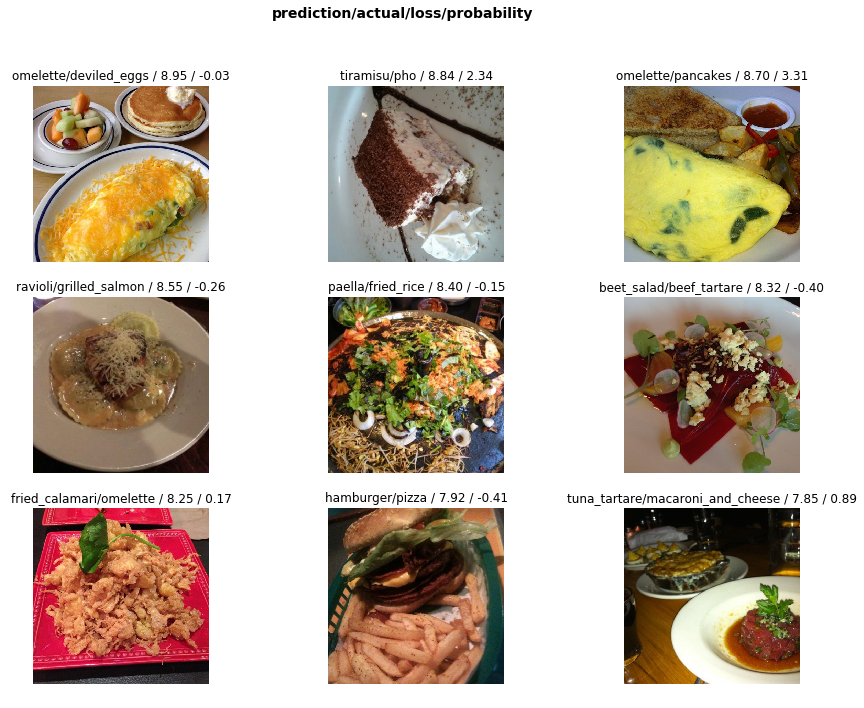

In [65]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

# TSNE Projections

In [53]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL

In [54]:
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_tta)

In [55]:
prob_df = pd.DataFrame(np.concatenate((probs_trans, y[:,None]), axis=1), columns=['x','y','labels'])

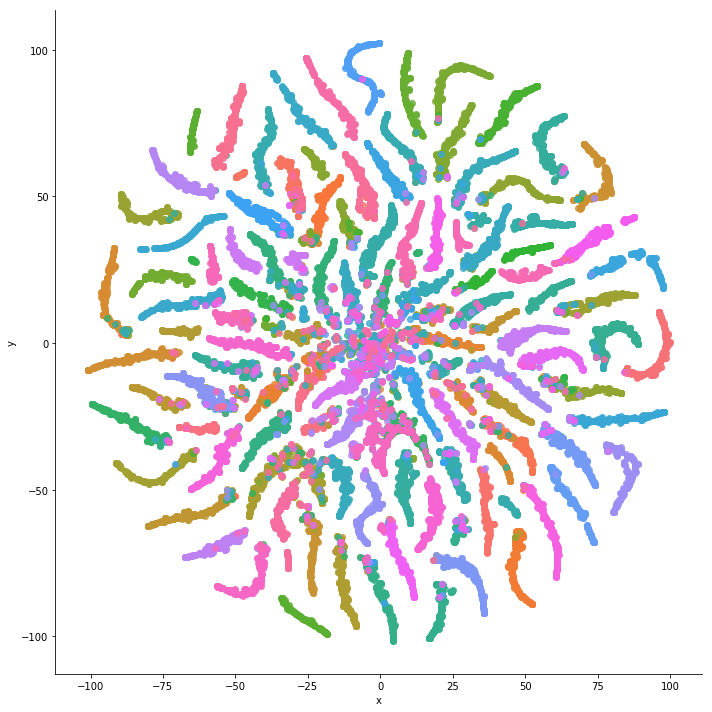

In [56]:
g = sns.lmplot('x', 'y', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10)

Here we cluster the same categories as in the previous notebook.

In [57]:
cats = ['steak', 'filet_mignon', 'tuna_tartare', 'beef_tartare', 'prime_rib', 'pork_chop']

codes = [data_test.classes.index(i) for i in cats]

bad_preds = [preds_tta[y==i] for i in codes]
bad_ys = [y_tta[y==i] for i in codes]

preds_stack = torch.cat(bad_preds, dim=0)
ys_stack = torch.cat(bad_ys, dim=0)

In [58]:
bad_tsne = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_stack)

In [59]:
bad_df = pd.DataFrame(np.concatenate((bad_tsne, ys_stack[:,None]), axis=1), columns=['x','y','labels'])

With commonly confused classes, we see even more cluster mixing than with the image augmentation model.

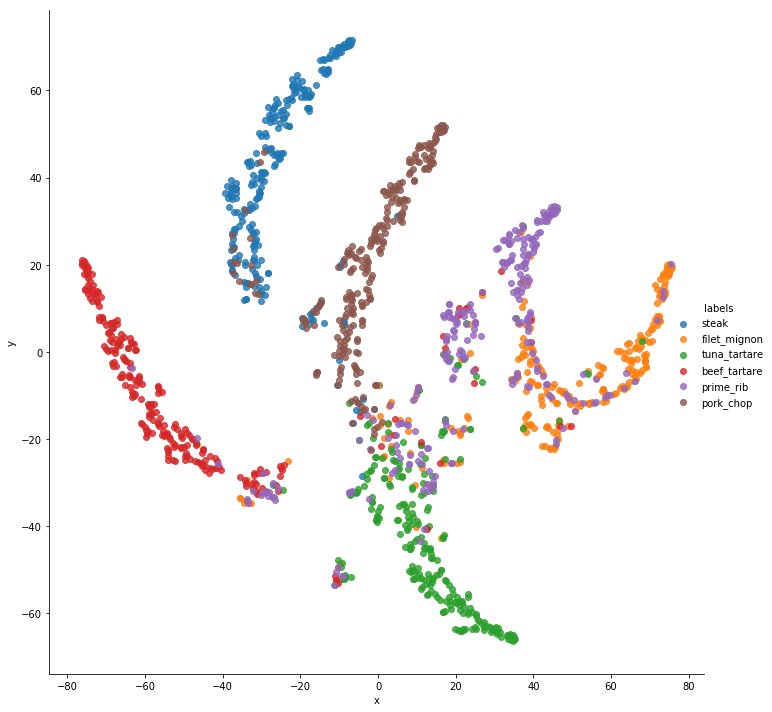

In [60]:
h = sns.lmplot('x', 'y', data=bad_df, hue='labels', fit_reg=False, legend=True, height=10)
for t, l in zip(h._legend.texts, cats): t.set_text(l)


In [61]:
cats = ['red_velvet_cake', 'risotto', 'waffles', 'apple_pie', 'garlic_bread', 'french_fries']

codes = [data_test.classes.index(i) for i in cats]

bad_preds = [preds_tta[y==i] for i in codes]
bad_ys = [y_tta[y==i] for i in codes]

preds_stack = torch.cat(bad_preds, dim=0)
ys_stack = torch.cat(bad_ys, dim=0)

In [62]:
bad_tsne = manifold.TSNE(n_components=2, perplexity=10).fit_transform(preds_stack)

In [63]:
bad_df = pd.DataFrame(np.concatenate((bad_tsne, ys_stack[:,None]), axis=1), columns=['x','y','labels'])

With well classified classes, we still see pretty good clustering

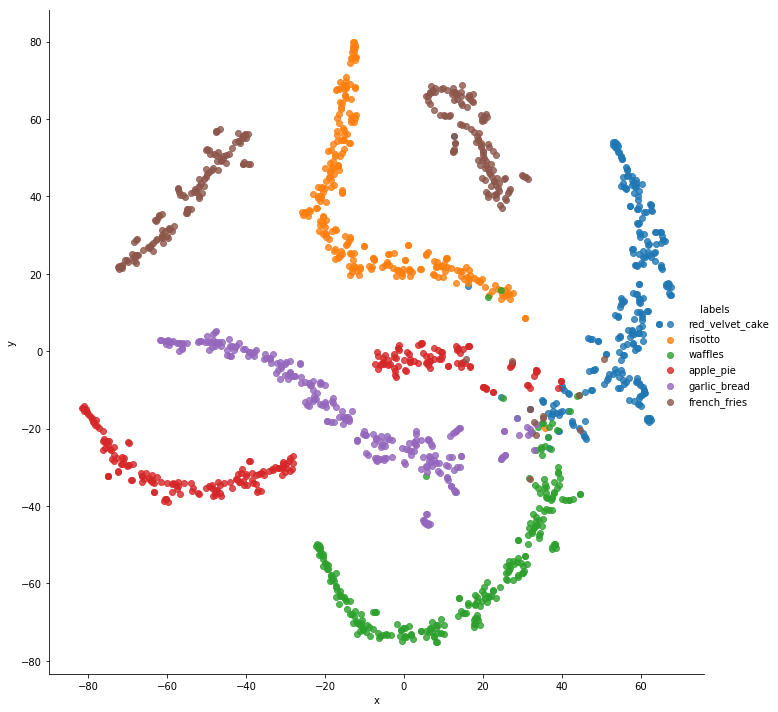

In [64]:
h = sns.lmplot('x', 'y', data=bad_df, hue='labels', fit_reg=False, legend=True, height=10)
for t, l in zip(h._legend.texts, cats): t.set_text(l)
